The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1
!pip install -U mxnet-cu101==1.7.0


# Máquinas de Fatoração

Máquinas de fatoração (FM) :cite:`Rendle.2010`, proposto por Steffen Rendle em 2010, é um algoritmo supervisionado que pode ser usado para tarefas de classificação, regressão e classificação. Rapidamente percebeu e se tornou um método popular e impactante para fazer previsões e recomendações. Particularmente, é uma generalização do modelo de regressão linear e do modelo de fatoração de matriz. Além disso, é uma reminiscência de máquinas de vetores de suporte com um kernel polinomial. Os pontos fortes das máquinas de fatoração sobre a regressão linear e a fatoração de matriz são: (1) ela pode modelar interações de variáveis ​​$\chi$, onde $\chi$ é o número da ordem polinomial e geralmente é definido como dois. (2) Um algoritmo de otimização rápido associado a máquinas de fatoração pode reduzir o tempo de computação polinomial à complexidade linear, tornando-o extremamente eficiente, especialmente para entradas esparsas de alta dimensão. Por essas razões, as máquinas de fatoração são amplamente utilizadas na propaganda moderna e na recomendação de produtos. Os detalhes técnicos e implementações são descritos abaixo.


## Máquinas de fatoração de 2 vias

Formalmente, deixe $x \in \mathbb{R}^d$ denotar os vetores de característica de uma amostra, e $y$ denotar o rótulo correspondente que pode ser um rótulo de valor real ou rótulo de classe, como classe binária "clique/não clique". O modelo para uma máquina de fatoração de grau dois é definido como:

$$
\hat{y}(x) = \mathbf{w}_0 + \sum_{i=1}^d \mathbf{w}_i x_i + \sum_{i=1}^d\sum_{j=i+1}^d \langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j
$$

onde $\mathbf{w}_0 \in \mathbb{R}$ é a tendência global; $\mathbf{w} \in \mathbb{R}^d$ denota os pesos da i-ésima variável; $\mathbf{V} \in \mathbb{R}^{d\times k}$ representa os embeddings de recursos; $\mathbf{v}_i$ representa a $i^\mathrm{th}$ linha de $\mathbf{V}$; $k$ é a dimensionalidade dos fatores latentes; $\langle\cdot, \cdot \rangle$ é o produto escalar de dois vetores. $\langle \mathbf{v}_i, \mathbf{v}_j \rangle$ modela a interação entre o recurso $i^\mathrm{th}$ e $j^\mathrm{th}$. Algumas interações de recursos podem ser facilmente compreendidas para que possam ser projetadas por especialistas. No entanto, a maioria das outras interações de recursos estão ocultas nos dados e são difíceis de identificar. Portanto, a modelagem de interações de recursos automaticamente pode reduzir muito os esforços na engenharia de recursos. É óbvio que os dois primeiros termos correspondem ao modelo de regressão linear e o último termo é uma extensão do modelo de fatoração de matriz. Se o recurso $i$ representa um item e o recurso $j$ representa um usuário, o terceiro termo é exatamente o produto escalar entre o usuário e os embeddings de item. É importante notar que o FM também pode generalizar para ordens superiores (grau> 2). No entanto, a estabilidade numérica pode enfraquecer a generalização.
 

## Um critério de otimização eficiente

Otimizar as máquinas de fatoração em um método direto leva a uma complexidade de $\mathcal{O}(kd^2)$, pois todas as interações de pares precisam ser calculadas. Para resolver esse problema de ineficiência, podemos reorganizar o terceiro termo do FM, o que poderia reduzir muito o custo de computação, levando a uma complexidade de tempo linear ($\mathcal{O}(kd)$). A reformulação do termo de interação aos pares é a seguinte:

$$
\begin{aligned}
&\sum_{i=1}^d \sum_{j=i+1}^d \langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j \\
 &= \frac{1}{2} \sum_{i=1}^d \sum_{j=1}^d\langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j - \frac{1}{2}\sum_{i=1}^d \langle\mathbf{v}_i, \mathbf{v}_i\rangle x_i x_i \\
 &= \frac{1}{2} \big (\sum_{i=1}^d \sum_{j=1}^d \sum_{l=1}^k\mathbf{v}_{i, l} \mathbf{v}_{j, l} x_i x_j - \sum_{i=1}^d \sum_{l=1}^k \mathbf{v}_{i, l} \mathbf{v}_{i, l} x_i x_i \big)\\
 &=  \frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i) (\sum_{j=1}^d \mathbf{v}_{j, l}x_j) - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2 \big ) \\
 &= \frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i)^2 - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2)
 \end{aligned}
$$


Com essa reformulação, a complexidade do modelo diminui bastante. Além disso, para recursos esparsos, apenas elementos diferentes de zero precisam ser calculados para que a complexidade geral seja linear ao número de recursos diferentes de zero.

Para aprender o modelo FM, podemos usar a perda de MSE para tarefas de regressão, a perda de entropia cruzada para tarefas de classificação e a perda de BPR para tarefas de classificação. Otimizadores padrão como SGD e Adam são viáveis para otimização.


In [1]:
import os
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## Implementação do Modelo
O código a seguir implementa as máquinas de fatoração. É claro que o FM consiste em um bloco de regressão linear e um bloco de interação de recursos eficiente. Aplicamos uma função sigmóide sobre a pontuação final, pois tratamos a previsão de CTR como uma tarefa de classificação.


In [2]:
class FM(nn.Block):
    def __init__(self, field_dims, num_factors):
        super(FM, self).__init__()
        num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Dense(1, use_bias=True)

    def forward(self, x):
        square_of_sum = np.sum(self.embedding(x), axis=1) ** 2
        sum_of_square = np.sum(self.embedding(x) ** 2, axis=1)
        x = self.linear_layer(self.fc(x).sum(1)) \
            + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True)
        x = npx.sigmoid(x)
        return x

## Carregue o conjunto de dados de publicidade
Usamos o wrapper de dados CTR da última seção para carregar o conjunto de dados de publicidade online.


In [3]:
batch_size = 2048
data_dir = d2l.download_extract('ctr')
train_data = d2l.CTRDataset(os.path.join(data_dir, 'train.csv'))
test_data = d2l.CTRDataset(os.path.join(data_dir, 'test.csv'),
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults)
train_iter = gluon.data.DataLoader(
    train_data, shuffle=True, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(
    test_data, shuffle=False, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())

## Treine o modelo
Depois, treinamos o modelo. A taxa de aprendizagem é definida como 0,02 e o tamanho de incorporação é definido como 20 por padrão. O otimizador `Adam` e a perda `SigmoidBinaryCrossEntropyLoss` são usados para o treinamento do modelo.


loss 0.504, train acc 0.263, test acc 0.265
185052.4 examples/sec on [gpu(0), gpu(1)]


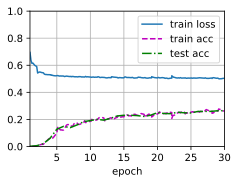

In [4]:
devices = d2l.try_all_gpus()
net = FM(train_data.field_dims, num_factors=20)
net.initialize(init.Xavier(), ctx=devices)
lr, num_epochs, optimizer = 0.02, 30, 'adam'
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {'learning_rate': lr})
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## Sumário

* FM é uma estrutura geral que pode ser aplicada em uma variedade de tarefas, como regressão, classificação e classificação.
* A interação / cruzamento de recursos é importante para tarefas de previsão e a interação bidirecional pode ser modelada de forma eficiente com FM.

## Exercícios

* Você pode testar FM em outro conjunto de dados, como Avazu, MovieLens e conjuntos de dados Criteo?
* Varie o tamanho de incorporação para verificar seu impacto no desempenho. Você consegue observar um padrão semelhante ao da fatoração da matriz?


[Discussão](https://discuss.d2l.ai/t/406)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTU5NDI2NDM2Ml19
-->
